### 模擬回測，算出pnl、total trade、unclosed position

In [30]:
def stimulate(data,entry_threshold,cost,exp_earn,unit_size,possibility,interval):
    exit_threshold = cost + exp_earn
    unit = 1
    A_positions = 0
    B_positions = 0
    entry_long_prices = []
    entry_short_prices = []
    avg_long_price = 0
    avg_short_price = 0
    trade_records = []
    A_cash = 100000
    B_cash = 100000
    cash_flow = []
    pnl = 0
    pnl_history = []
    
    for i in range(len(data)):
        spread = data['spread'].iloc[i]

        if spread > entry_threshold and A_positions <= 0 and A_cash > 0:
            if trade_records != [] and trade_records[-1]['direction'] == 'short' and i - trade_records[-1]['time'] < interval:
                continue #用來判斷連續行情不重複下單的情況
            else:
                A_positions -= unit
                entry_short_prices.append(spread)
                avg_short_price = sum(entry_short_prices) / len(entry_short_prices)
                trade_records.append({'time': i, 'Spread': spread, 'avg_short_price': avg_short_price, 'direction': 'short','A_position':A_positions})

                A_cash -= unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'short'})

        elif spread < -entry_threshold and B_positions <= 0 and B_cash > 0:
            if trade_records != [] and trade_records[-1]['direction'] == 'long' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                B_positions -= unit
                entry_long_prices.append(spread)
                avg_long_price = sum(entry_long_prices) / len(entry_long_prices)
                trade_records.append({'time': i, 'Spread': spread, 'avg_long_price': avg_long_price, 'direction': 'long','B_position':B_positions})

                B_cash -= unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'long'})

        if avg_short_price - spread > exit_threshold and A_positions < 0 :
            if trade_records[-1]['direction'] == 'close short' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                A_positions += unit
                pnl += (avg_short_price - spread - cost) * unit_size * possibility

                pnl_history.append({'time': i, 'PnL': pnl})
                trade_records.append({'time': i, 'Spread': spread, 'avg_short_price': avg_short_price, 'direction': 'close short','A_position':A_positions})
                A_cash += unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'close short'})

        elif spread - avg_long_price > exit_threshold  and B_positions < 0 :
            if trade_records[-1]['direction'] == 'close long' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                B_positions += unit
                pnl += (spread - avg_long_price - cost) * unit_size * possibility

                pnl_history.append({'time': i, 'PnL': pnl})
                trade_records.append({'time': i, 'Spread': spread, 'avg_long_price': avg_long_price, 'direction': 'close long','B_position':B_positions})
                B_cash += unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'close long'})


    trade_records_df = pd.DataFrame(trade_records)

    trade_records_df['short'] = trade_records_df['Spread'][trade_records_df['direction'] == 'short']
    trade_records_df['close short'] = trade_records_df['Spread'][trade_records_df['direction'] == 'close short']
    trade_records_df['long'] = trade_records_df['Spread'][trade_records_df['direction'] == 'long']
    trade_records_df['close long'] = trade_records_df['Spread'][trade_records_df['direction'] == 'close long']


    short_bybit = trade_records_df['short'].count() 
    close_bybit = trade_records_df['close short'].count()
    short_bitget = trade_records_df['long'].count()
    close_bitget = trade_records_df['close long'].count()
    total_trade = len(trade_records_df)
    unclosed_position = short_bybit - close_bybit + short_bitget - close_bitget
    
    return round(pnl / 100,5)#,total_trade,unclosed_position

##### 不同參數下的pnl

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


bitget_df = pd.read_csv('C:\\Users\\Intern\\Documents\\intern_research_nb\\bitget\\1m_BTC.csv')
bitget = bitget_df[:-3]
bybit = pd.read_csv('C:\\Users\\Intern\\Documents\\intern_research_nb\\bybit\\1m_BTC.csv')
spread = ((bybit['close'] - bitget['close'].astype(float)) / ((bybit['close'] + bitget['close'].astype(float)) / 2)) * 100

data = pd.DataFrame()
data['spread'] = spread
data['bitget'] = bitget['close'].astype(float)
data['bybit'] = bybit['close']

entry_threshold = 0.05
cost = 0.065
exp_earn = 0.01
exit_threshold = cost + exp_earn
unit_size = 1000
possibility = 1 #定義每次的profit獲利空間
interval = 5  #如果行情發生的時候我們在時間內平均多少次orderbook更新才能成交一次

table = {}

for exp_earn in np.arange(0.01,0.075,0.005):
    info = []
    for possibility in np.arange(1,0.2,-0.1):
        # round(pnl / 100,5),total_trade,unclosed_position
        pnl = stimulate(data,entry_threshold,cost,exp_earn,unit_size,possibility,interval) 
        info.append(pnl)
    table[round(exp_earn,2)] = info
table

{0.01: [120.36286,
  108.32657,
  96.29028,
  84.254,
  72.21771,
  60.18143,
  48.14514,
  36.10886],
 0.02: [156.50552,
  140.85496,
  125.20441,
  109.55386,
  93.90331,
  78.25276,
  62.60221,
  46.95165],
 0.03: [159.94001,
  143.94601,
  127.95201,
  111.95801,
  95.96401,
  79.97001,
  63.976,
  47.982],
 0.04: [100.35834,
  90.32251,
  80.28668,
  70.25084,
  60.21501,
  50.17917,
  40.14334,
  30.1075],
 0.05: [72.48035,
  65.23231,
  57.98428,
  50.73624,
  43.48821,
  36.24017,
  28.99214,
  21.7441],
 0.06: [74.84482,
  67.36034,
  59.87586,
  52.39138,
  44.90689,
  37.42241,
  29.93793,
  22.45345],
 0.07: [48.9389,
  44.04501,
  39.15112,
  34.25723,
  29.36334,
  24.46945,
  19.57556,
  14.68167]}

### example : exp_earn vs possibility

In [34]:
possibility = ['100%','90%','80%','70%','60%','50%','40%','30%']

table_df = pd.DataFrame(table)
df = table_df.T
df.columns = possibility
df.index.name = 'exp return'
df.columns.name = 'possibility'
df

possibility,100%,90%,80%,70%,60%,50%,40%,30%
exp return,,,,,,,,
0.01,120.36286,108.32657,96.29028,84.25400,72.21771,60.18143,48.14514,36.10886
0.02,156.50552,140.85496,125.20441,109.55386,93.90331,78.25276,62.60221,46.95165
0.03,159.94001,143.94601,127.95201,111.95801,95.96401,79.97001,63.97600,47.98200
0.04,100.35834,90.32251,80.28668,70.25084,60.21501,50.17917,40.14334,30.10750
0.05,72.48035,65.23231,57.98428,50.73624,43.48821,36.24017,28.99214,21.74410
0.06,74.84482,67.36034,59.87586,52.39138,44.90689,37.42241,29.93793,22.45345
0.07,48.93890,44.04501,39.15112,34.25723,29.36334,24.46945,19.57556,14.68167


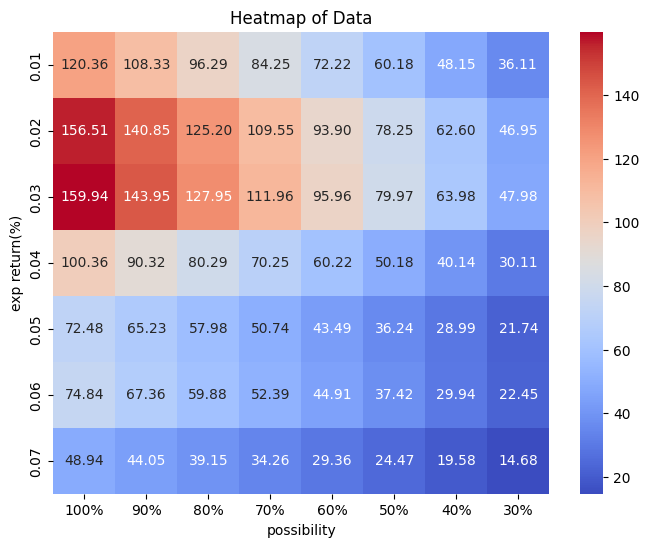

In [36]:
import seaborn as sns
from matplotlib.ticker import FixedFormatter, FixedLocator

plt.figure(figsize=(8, 6))
ax = sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)

ax.set_title('Heatmap of Data')
ax.set_xlabel('possibility')
ax.set_ylabel('exp return(%)')


plt.show()

In [40]:
import pandas as pd
import hiplot as hip

exp_earn_values = [0.01,0.02,0.03]#,0.04,0.05,0.06,0.07]
possibility_values = [1,0.9,0.8]#,0.7,0.6,0.5,0.4,0.3]
interval_values = [1,3,5]#,10,15,20,25,30]
unit_size_values = [50,100,200]#,250,400,500,1000,2000]

results = pd.DataFrame(columns=['exp_earn', 'possibility', 'interval', 'unit_size', 'result'])

for exp_earn in exp_earn_values:
    for possibility in possibility_values:
        for interval in interval_values:
            for unit_size in unit_size_values:
                result = stimulate(data, entry_threshold, cost, exp_earn, unit_size, possibility, interval)
                results.loc[len(results)] = {'exp_earn': exp_earn, 'possibility': possibility, 'interval': interval, 'unit_size': unit_size, 'pnl': result}

hip.Experiment.from_dataframe(results).display(force_full_width=True)


<IPython.core.display.Javascript object>

short bybit chances  : 181
short bitget chances : 273
close bybit chances  : 181
close bitget chances : 249
total trading times  : 884
unclosed positions   : 24
unrealized profit    : 2.4000000000000004
total pnl            : 160.76826
----------------------------


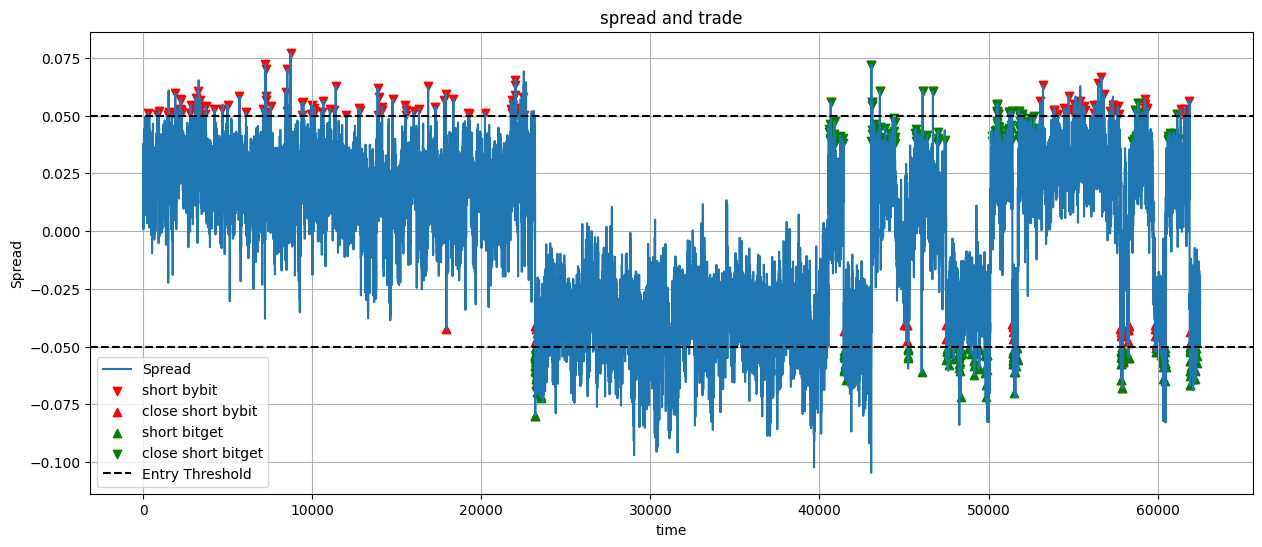

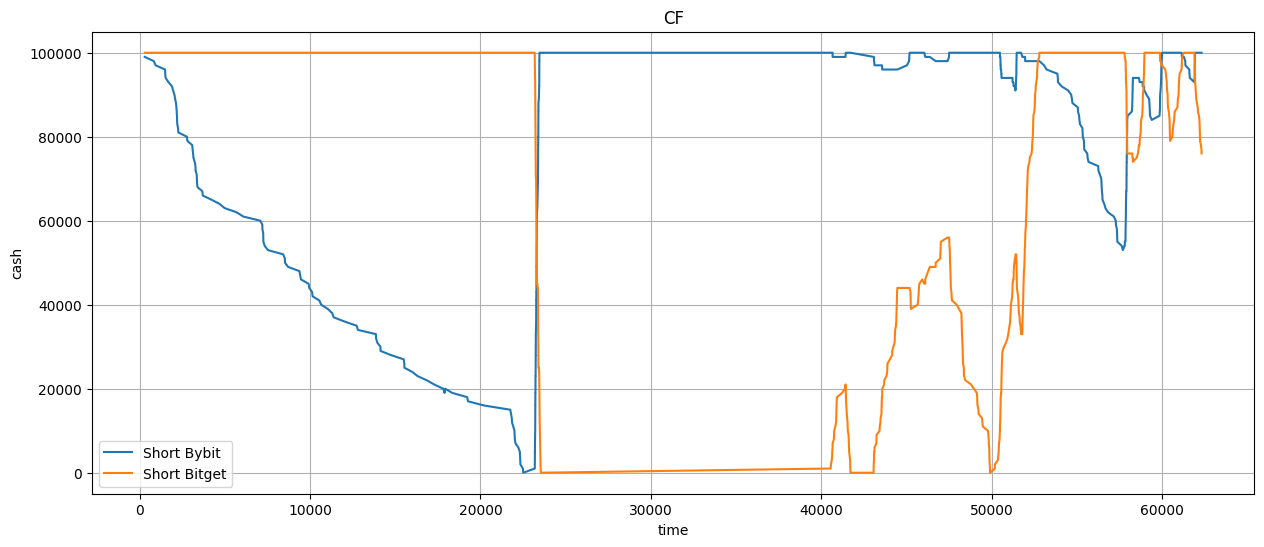

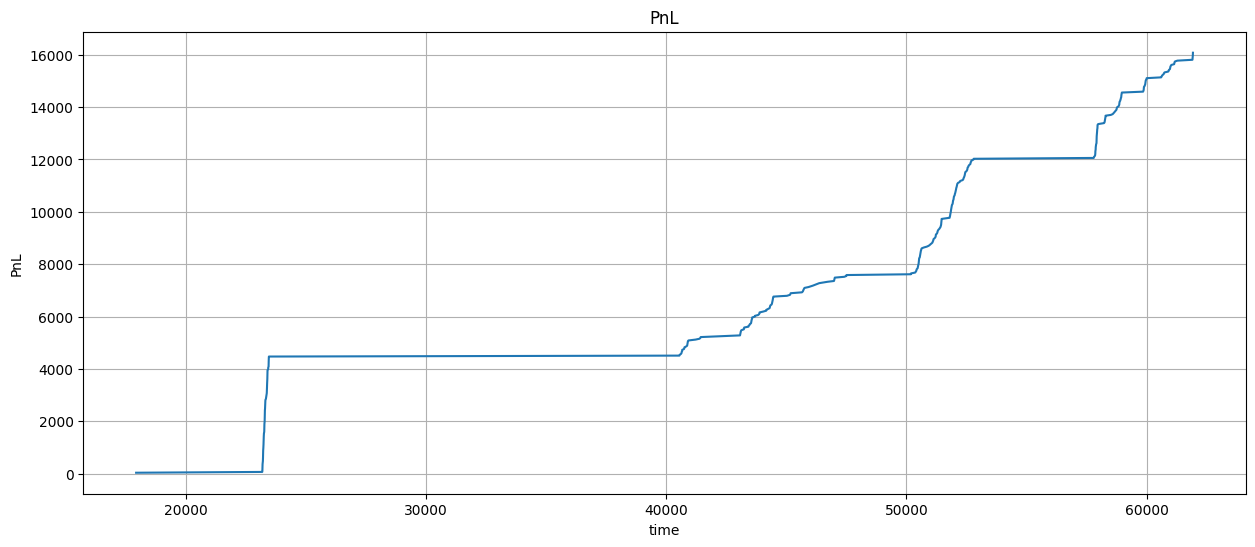

In [17]:
entry_threshold = 0.05
cost = 0.065
exp_earn = 0.03
exit_threshold = cost + exp_earn
unit_size = 1000
possibility = 1 #定義每次的profit獲利空間
interval = 5  #如果行情發生的時候我們在時間內平均多少次orderbook更新才能成交一次

exit_threshold = cost + exp_earn
unit = 1
A_positions = 0
B_positions = 0
entry_long_prices = []
entry_short_prices = []
avg_long_price = 0
avg_short_price = 0
trade_records = []
A_cash = 100000
B_cash = 100000
cash_flow = []
pnl = 0
pnl_history = []

for i in range(len(data)):
        spread = data['spread'].iloc[i]

        if spread > entry_threshold and A_positions <= 0 and A_cash > 0:
            if trade_records != [] and trade_records[-1]['direction'] == 'short' and i - trade_records[-1]['time'] < interval:
                continue #用來判斷連續行情不重複下單的情況
            else:
                A_positions -= unit
                entry_short_prices.append(spread)
                avg_short_price = sum(entry_short_prices) / len(entry_short_prices)
                trade_records.append({'time': i, 'Spread': spread, 'avg_short_price': avg_short_price, 'direction': 'short','A_position':A_positions})

                A_cash -= unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'short'})

        elif spread < -entry_threshold and B_positions <= 0 and B_cash > 0:
            if trade_records != [] and trade_records[-1]['direction'] == 'long' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                B_positions -= unit
                entry_long_prices.append(spread)
                avg_long_price = sum(entry_long_prices) / len(entry_long_prices)
                trade_records.append({'time': i, 'Spread': spread, 'avg_long_price': avg_long_price, 'direction': 'long','B_position':B_positions})

                B_cash -= unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'long'})

        if avg_short_price - spread > exit_threshold and A_positions < 0 :
            if trade_records[-1]['direction'] == 'close short' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                A_positions += unit
                pnl += (avg_short_price - spread - cost) * unit_size * possibility

                pnl_history.append({'time': i, 'PnL': pnl})
                trade_records.append({'time': i, 'Spread': spread, 'avg_short_price': avg_short_price, 'direction': 'close short','A_position':A_positions})
                A_cash += unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'close short'})

        elif spread - avg_long_price > exit_threshold  and B_positions < 0 :
            if trade_records[-1]['direction'] == 'close long' and i - trade_records[-1]['time'] < interval:
                continue
            else:
                B_positions += unit
                pnl += (spread - avg_long_price - cost) * unit_size * possibility

                pnl_history.append({'time': i, 'PnL': pnl})
                trade_records.append({'time': i, 'Spread': spread, 'avg_long_price': avg_long_price, 'direction': 'close long','B_position':B_positions})
                B_cash += unit * unit_size
                cash_flow.append({'time': i, 'A_Cash': A_cash, 'B_cash': B_cash, 'direction': 'close long'})


trade_records_df = pd.DataFrame(trade_records)

cash_flow_df = pd.DataFrame(cash_flow)
pnl_history_df = pd.DataFrame(pnl_history)
trade_records_df['short'] = trade_records_df['Spread'][trade_records_df['direction'] == 'short']
trade_records_df['close short'] = trade_records_df['Spread'][trade_records_df['direction'] == 'close short']
trade_records_df['long'] = trade_records_df['Spread'][trade_records_df['direction'] == 'long']
trade_records_df['close long'] = trade_records_df['Spread'][trade_records_df['direction'] == 'close long']


short_bybit = trade_records_df['short'].count() 
close_bybit = trade_records_df['close short'].count()
short_bitget = trade_records_df['long'].count()
close_bitget = trade_records_df['close long'].count()

print(f'short bybit chances  : {short_bybit}')
print(f'short bitget chances : {short_bitget}')
print(f'close bybit chances  : {close_bybit}')
print(f'close bitget chances : {close_bitget}')
print(f'total trading times  : {len(trade_records_df)}')
print(f'unclosed positions   : {short_bybit - close_bybit + short_bitget - close_bitget}')
print(f'unrealized profit    : {0.01 * 10 * (short_bybit - close_bybit + short_bitget - close_bitget)}')
print(f'total pnl            : {round(pnl / 100,5)}')
print(f'----------------------------')


plt.figure(figsize=(15, 6))
plt.plot(data.index, data['spread'], label='Spread')
plt.scatter(trade_records_df['time'], trade_records_df['short'], c='red',marker='v', label='short bybit')
plt.scatter(trade_records_df['time'], trade_records_df['close short'], c='red',marker='^', label='close short bybit')
plt.scatter(trade_records_df['time'], trade_records_df['long'], c='g',marker='^', label='short bitget')
plt.scatter(trade_records_df['time'], trade_records_df['close long'], c='g',marker='v', label='close short bitget')
plt.axhline(y=entry_threshold, color='k', linestyle='--', label='Entry Threshold')
plt.axhline(y=-entry_threshold, color='k', linestyle='--')
plt.xlabel('time')
plt.ylabel('Spread')
plt.legend()
plt.title('spread and trade')
plt.grid(True)
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(cash_flow_df['time'], cash_flow_df['A_Cash'], label='Short Bybit')
plt.plot(cash_flow_df['time'], cash_flow_df['B_cash'], label='Short Bitget')
plt.xlabel('time')
plt.ylabel('cash')
plt.legend()
plt.title('CF')
plt.grid(True)
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(pnl_history_df['time'], pnl_history_df['PnL'])
plt.xlabel('time')
plt.ylabel('PnL')
plt.title('PnL')
plt.grid(True)
plt.show()

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 4000)
trade_records_df